## Import & Setup

In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## SPT-DES Richness-Mass relation

This is in M500c mass. Need to convert to M200c. 

In [3]:
len_lob_gird=50
lobs_grid_DESxSPT=np.linspace(15.,200,len_lob_gird)
means_m_DESxSPT=np.loadtxt('mean_M_lob_SPTRM_36_v1.txt')

#### Flatten the array so as to convert using the coloussus module. 

In [4]:
m_flatten_DESxSPT = np.ravel(means_m_DESxSPT)
m_shape = means_m_DESxSPT.shape
print(m_shape)
print(m_flatten_DESxSPT.shape)

(250, 50)
(12500,)


#### Converting from M500c to M200c

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_defs

cosmology.setCosmology('planck15')
c500c = concentration.concentration(m_flatten_DESxSPT, '500c', 0.35, model = 'diemer19')
M200c_DESxSPT, R200c, c200c = mass_defs.changeMassDefinition(m_flatten_DESxSPT, c500c, 0.35, '500c', '200c')

Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.


In [6]:
M200c_DESxSPT = np.reshape(M200c_DESxSPT, m_shape)

### Plotting the M200c Converted Mass Richness Relation

In [7]:
lobs_grid_DESxSPT

array([ 15.        ,  18.7755102 ,  22.55102041,  26.32653061,
        30.10204082,  33.87755102,  37.65306122,  41.42857143,
        45.20408163,  48.97959184,  52.75510204,  56.53061224,
        60.30612245,  64.08163265,  67.85714286,  71.63265306,
        75.40816327,  79.18367347,  82.95918367,  86.73469388,
        90.51020408,  94.28571429,  98.06122449, 101.83673469,
       105.6122449 , 109.3877551 , 113.16326531, 116.93877551,
       120.71428571, 124.48979592, 128.26530612, 132.04081633,
       135.81632653, 139.59183673, 143.36734694, 147.14285714,
       150.91836735, 154.69387755, 158.46938776, 162.24489796,
       166.02040816, 169.79591837, 173.57142857, 177.34693878,
       181.12244898, 184.89795918, 188.67346939, 192.44897959,
       196.2244898 , 200.        ])

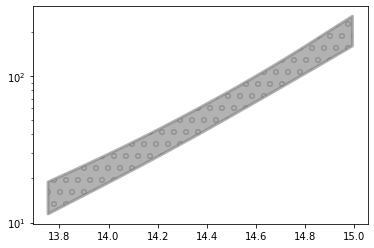

In [8]:
# DES NC+SPT-OMR ===================================
from scipy.interpolate import InterpolatedUnivariateSpline as ius #interpolation

log10M200c_DESxSPT=np.mean(np.log10(M200c_DESxSPT),axis=0)

lo_mass=ius(np.log(lobs_grid_DESxSPT[:]), (log10M200c_DESxSPT-np.std(np.log10(M200c_DESxSPT), axis=0)), k=1)
hi_mass=ius(np.log(lobs_grid_DESxSPT[:]), (log10M200c_DESxSPT+np.std(np.log10(M200c_DESxSPT), axis=0)), k=1)
mean_mass = ius(np.log(lobs_grid_DESxSPT[:]), (log10M200c_DESxSPT), k=1)

lo_richness = ius((log10M200c_DESxSPT-2*np.std(np.log10(M200c_DESxSPT),axis=0)), np.log(lobs_grid_DESxSPT[:]), k=1)
hi_richness = ius((log10M200c_DESxSPT+2*np.std(np.log10(M200c_DESxSPT),axis=0)), np.log(lobs_grid_DESxSPT[:]), k=1)

samp_lo=np.exp(lo_richness((log10M200c_DESxSPT)))
samp_hi=np.exp(hi_richness((log10M200c_DESxSPT)))

plt.fill_between(log10M200c_DESxSPT, samp_lo, samp_hi,color='gray',hatch='o',alpha=0.6,lw=3,label='DES-NC+SPT-OMR')
plt.yscale('log')

## To do next
* Apply KLLR to the SAGE galaxy catalog
* Compare slope with the MOR using DES vs SPT.
* Make a plot (with inset maybe) side by side DESxSPT vs. SAGE

Create a plot of the different richness-mass relations exhibited in different definitions of the Ngal. 

### Apply KLLR

In [9]:
import sys
sys.path.append('/global/u1/z/zzhang13')

from mcmc_full_models import *
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

nBootstrap=100

from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [10]:
kllr_nbins= 6
kernel_type = 'gaussian'
kernel_width = 0.2

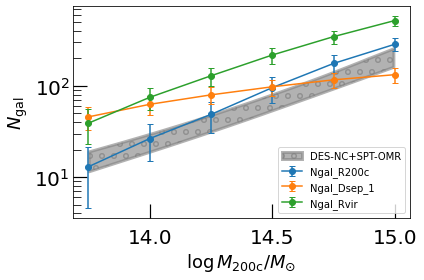

In [11]:
## Todo: Create better error bars. 

Ngal_defs = ['Ngal_R200c', 'Ngal_Dsep_1', 'Ngal_Rvir']

## Iterate through the Ngal definition
for Ngal_def in Ngal_defs:
    cur_df = matched_halo_df[(matched_halo_df['M200c'] > 10**13.75) & (matched_halo_df[Ngal_def] < 10**15)]

    ##Testing the KLLR algorithm
    #Residuals as calculated from KLLR
    lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
    xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.array(np.log10(cur_df['M200c'])), np.array(cur_df[Ngal_def]), \
                                                                  bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

    dy_kllr = lm.residuals(np.array(np.log10(cur_df['M200c'])), np.array(cur_df[Ngal_def]), bins=kllr_nbins, nBootstrap = 1,
                          fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)

    
    ##Plotting for each definition
    plt.errorbar(xline,yline, yerr=scatter, fmt ='o', linestyle='solid', capsize=3,  label=Ngal_def)
    
plt.fill_between(log10M200c_DESxSPT, samp_lo, samp_hi,color='gray',hatch='o',alpha=0.6, lw=3,label='DES-NC+SPT-OMR')
plt.legend()
plt.yscale('log')
plt.ylabel(r'$N_{\rm gal}$', fontsize=18)
plt.xlabel(r'$\log{M_{\rm 200c}/M_{\odot}}$', fontsize=18)
plt.tight_layout()
plt.savefig(plotdir+'MOR_MDPL2_vs_data.pdf')
plt.show()